In [23]:
import pandas as pd
import joblib
import shap
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular
from dalex import Explainer
import plotly.graph_objects as go
from shapash.explainer.smart_explainer import SmartExplainer

# Load the input_train_balanced dataset
input_train_balanced = pd.read_csv('intput_train_balanced.csv')
# Load the model
model = joblib.load('model.sav')

## SHAP

Summary plot showing the impact of each feature on model predictions.

 98%|===================| 10331/10524 [01:25<00:01]        

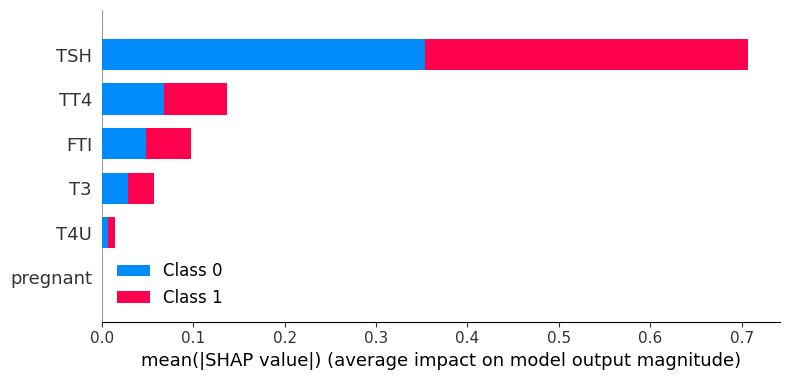

In [24]:
X_train = input_train_balanced.drop(['binaryClass'], axis=1)

# Create a SHAP explainer object
explainer = shap.Explainer(model, X_train)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train)

# Visualize SHAP summary plot
shap.summary_plot(shap_values, X_train)

The color of each point represents the feature's value. Blue indicates lower feature values, while red indicates higher feature values. This allows you to see how the feature value influences the model's prediction.

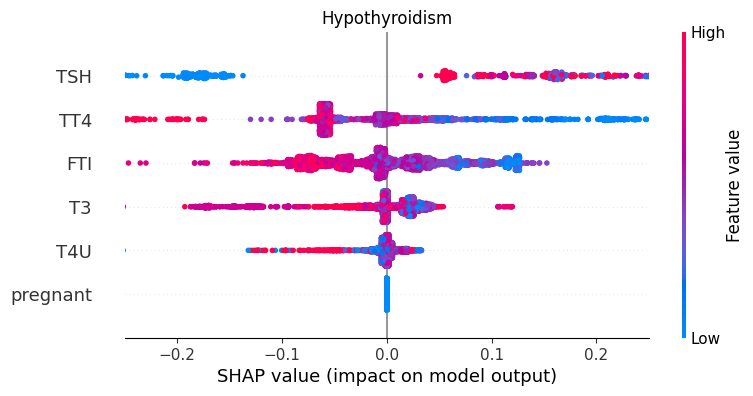

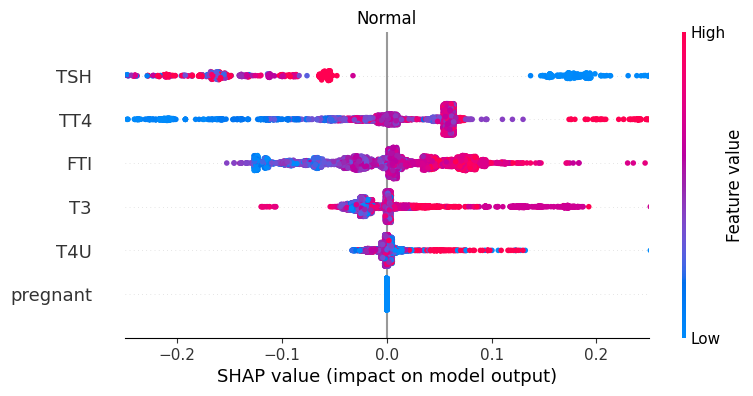

In [25]:
classes = ['Hypothyroidism', 'Normal']

for i in range(len(shap_values)):
    # Create a summary plot for the current output
    shap.summary_plot(shap_values[i], X_train, feature_names=X_train.columns, show=False)
    ax = plt.gca()
    ax.set_xlim(-0.25, 0.25) 
    
    plt.title(f'{classes[i]}')
    plt.rcParams["figure.figsize"] = [5,3]
    #save the plot figure in eps format
    #fig = plt.gcf()
    #fig.set_size_inches(3, 5)
    #fig.savefig(f'shap_{i}.pdf', format='pdf')
    plt.show()

# 0 : Hypo
# 1: Normal 


## LIME

In [26]:
y_train =input_train_balanced['binaryClass']
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, training_labels=y_train,  feature_names=X_train.columns, kernel_width=3, discretize_continuous=True, verbose=False)

In [27]:
predict_fn = lambda x: model.predict_proba(x)

In [28]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode='classification',
class_names=['Hypothyroidism', 'Normal'], training_labels=y_train, feature_names=X_train.columns)


In [29]:
input_train_balanced.head(-1)

,TT4,FTI,T3,TSH,T4U,pregnant,binaryClass
0,124.0,112.0,1.80,6.20,1.11,0,0
1,80.0,79.0,2.10,8.20,1.01,0,0
2,17.0,14.0,0.40,165.00,1.19,0,0
3,46.0,46.0,2.60,31.00,1.00,0,0
4,14.0,13.0,0.70,60.00,1.11,0,0
...,...,...,...,...,...,...,...
5256,122.0,73.0,2.30,0.02,1.66,0,1
5257,88.0,122.0,2.06,4.30,0.72,0,1
5258,110.0,101.0,2.70,2.40,1.09,0,1
5259,90.0,91.0,2.60,2.30,0.99,0,1


In [30]:
i = 50
input_train_balanced.iloc[i]

TT4             86.00
FTI            101.00
T3               1.20
TSH             11.00
T4U              0.85
pregnant         0.00
binaryClass      0.00
Name: 50, dtype: float64

/workspaces/thyroid_disease_AI/cilab/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



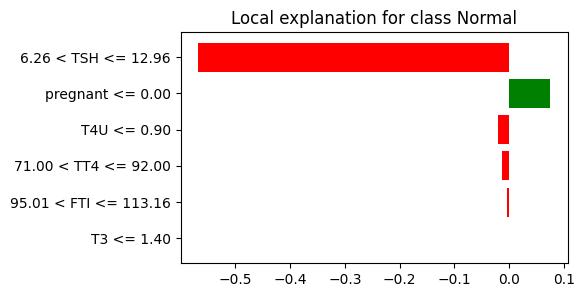

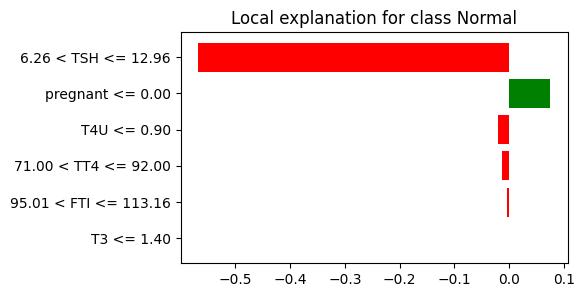

In [31]:
#print(X_train.loc[i,X_train.columns], y_train.loc[i])
exp=explainer.explain_instance(X_train.loc[i].values, predict_fn)
# increse font size
exp.show_in_notebook(show_table=False)
exp.as_pyplot_figure()

## DALEX

In [32]:
exp = Explainer(model, X_train, y_train)
vip = exp.model_parts()
fig = vip.plot(show=False)

Preparation of a new explainer is initiated

  -> data              : 5262 rows 6 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 5262 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x704e886963b0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.5, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.861, mean = -0.000384, max = 0.841
  -> model_info        : package sklearn

A new explainer has been created!


/workspaces/thyroid_disease_AI/cilab/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



In [33]:
fig.update_layout(
    title='',
    xaxis_title='',
    yaxis_title='', 
    font=dict(family='Arial', size=20, color='black'),
    width=800,
    height=500,
    showlegend=False,    
    template='none'
)
fig.show()

In [34]:
mp = exp.model_performance(model_type = 'classification')
mp.result

,recall,precision,f1,accuracy,auc
RandomForestClassifier,0.985937,0.99923,0.992539,0.992588,0.999958


In [35]:
pdp = exp.model_profile(variables=["TSH"])
fig = pdp.plot(show=False)

Calculating ceteris paribus: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


In [36]:
fig.update_xaxes(range=[0,100])
fig.update_layout(
    title='',
    xaxis_title='TSH values',
    yaxis_title='Class', 
    font=dict(family='Arial', size=20, color='black'),
    width=700,
    height=400,
    showlegend=False,    
    template='none'
)
fig.show()

## SHAPASH

In [37]:
# Criando o objeto SmartExplainer
xpl = SmartExplainer(model=model)
xpl.compile(
    X_train,
    y_pred=pd.Series(model.predict(X_train), index=X_train.index),
    y_target=y_train,
)

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x704e827266e0>


In [38]:
fig = xpl.plot.features_importance() # Visualizando informações sobre o modelo
# Update figure layout (e.g., title, axis labels)
fig.update_layout(
    title='Features importance',
    xaxis_title='Contribution',
    yaxis_title='Features', 
    font=dict(family='Arial', size=20, color='black'),
    width=700,
    height=400,
    showlegend=False,    
    template='none'
)


In [39]:
fig = xpl.plot.contribution_plot("TT4", proba=True)
fig.update_layout(
 
    font=dict(family='Arial', size=20, color='black'),
    width=700,
    height=400,
    showlegend=False,    
    template='none'
)

In [40]:
xpl.plot.local_plot(index=i) # Interpreta as previsões individuais


In [41]:
fig = xpl.plot.contribution_plot("TSH")
fig.update_layout(
 
    font=dict(family='Arial', size=20, color='black'),
    width=700,
    height=400,
    showlegend=False,    
    template='none'
)

In [42]:
#xpl.run_app(host='127.0.0.1') # Execute o aplicativo Shapash